# **Customer Sentiment and Survey Responses**

**Background:**

ACME is one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

At ACME we thrive for making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**Data Description:**

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me


Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

## **Importing Python packages and the data**

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import matplotlib.ticker as mtick
import matplotlib.style as style
import seaborn as sns
import scipy
from google.colab import files
from scipy.stats import randint, loguniform, expon
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics  
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection.partial_dependence import partial_dependence, plot_partial_dependence
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC, LinearSVC
import lightgbm as lgb
from mlxtend.classifier import StackingClassifier
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
style.use('seaborn-bright')

In [4]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving ACME-HappinessSurvey2020.csv to ACME-HappinessSurvey2020.csv


In [5]:
# Now, we can read the .csv file from desktop
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

## **Exploratory Data Analysis**

In [6]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Looks like the data is exclusively numeric and features have labels. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


It does not appear like there are any missing values here.  Additionally, the data types are integers.  We might be all set for modeling but let's do a little EDA first as I am curious about correlations and distributions of the data.

In [8]:
df.isnull().values.any()

False

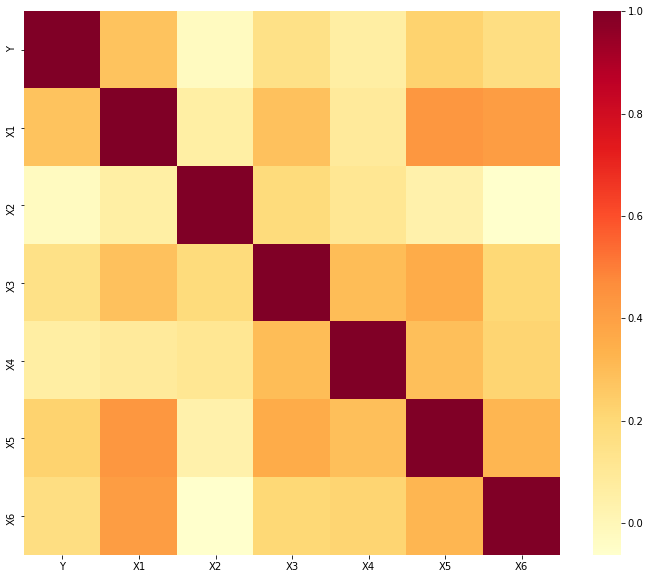

In [9]:
f, ax = plt.subplots(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap = 'YlOrRd')
plt.show()

It appears that there is a slight positive correlation of about 0.5 between X1 (my order was delivered on time) and X5 (I am satisfied with my courier) and X6 (the app makes ordering easy for me).  This makes sense because if the order was delivered on time, in most cases customers would be satisfied with the courier.  But, there are other instances where timeliness in not the only factor with regard to couriers.  Courier behavior (throwing packages, politeness, etc.) may also be of utmost importance to ACME.  Also, X3(ordered everything I wanted to order) and X5 (I am satisfied with my courier) could mean missing orders have occured.  The relationship between X1 (my order was delivered on time) and X6 (the app makes ordering easy for me) could make sense if customers were having a difficult time with the app and caused delays with regard to items that customers needed overnighted or for fast delivery. Fortunately, only X1 has a slightly high correlation with the target.

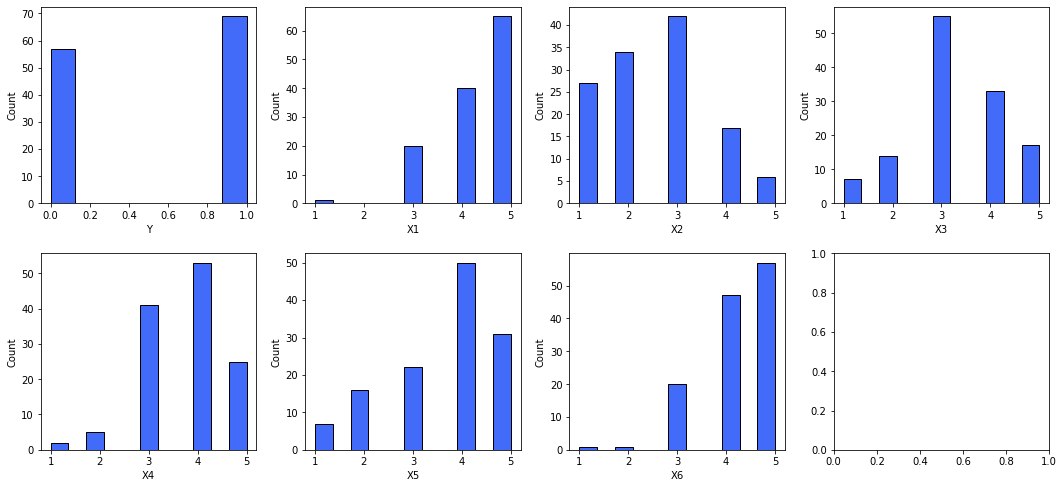

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 4)    # axes is 2d array (2x4)
axes = axes.flatten()         # Convert axes to 1d array 
fig.set_size_inches(15, 7)

for ax, col in zip(axes, df.columns):
  sns.histplot(df[col], ax = ax, kde = False, color='xkcd:vibrant blue')
  plt.tight_layout(pad=1.5)

Here, we see that X1, X4 and X6 have a large number of positive responses, which is good.  X5 is fairly positive but there are a large number of negative and neutral scores.  X3 is overwhelmingly neutral and X2 has a significant room for improvement!  It looks like customers are not receiving the right contents, meaning there might be something going on in the warehouse or logistics before the packages are delivered.  Additionally, we see that the ratio of happy and not happy customers is quite balanced, although I may choose to stratify the train-test split anyway.

In [17]:
df.var()

Y     0.249714
X1    0.640000
X2    1.242984
X3    1.047429
X4    0.766984
X5    1.317079
X6    0.654984
dtype: float64

As expected, there is not much difference in variance and no need for normalization. Now, the data set is ready for the modeling stage. We will set y to the target and we will start with all of the features for X.  A random seed will be set and a train-test split of 0.3 will be used initially as this data set is small.  We will begin with the champion of classifiers for small data sets - Random Forest.

## **Modeling**

In [19]:
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
X = df[features]
y = df['Y']

In [20]:
seed = 2346

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify = y)

In [22]:
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=seed)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2346, verbose=0,
                       warm_start=False)

In [23]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="accuracy")
scores.mean(), scores.std()

(0.54640522875817, 0.08888408291505992)

This accuracy is really low, let's see if we can optimize some hyperparameters to get a better accuracy or remove some features that are too correlated. We will create a pipeline so that we can take a look as several of my favorite machine learning algorithms together.

In [29]:
transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, features)]
)

In [73]:
o = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Logistic Regression', 'K Nearest Neighbors', 'Random Forest', 'AdaBoost', 'XGBoost'])

Let's start with a train and score model that will help us track the time for modeling.  This should not take too long with a small data set.  We will be using different parameter grids for each model.  We will start with 5-fold cross validation.  Grid Search will be used with logistic regression but we will use randomized search for the others as Random Forest can have a good number of hyperparameters.  XGBoost is a maverick of sorts and does not perform well on small data sets but I like to have it in my pipeline.

In [75]:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5):
    
    
    if model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv)
    elif model_name == 'XGBoost': 
        cv = RandomizedSearchCV(estimator, param_distributions = param_grid, cv = cv)
    else:
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, random_state=None)
    
    
    
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    o.loc['Time to Train', model_name] = ttt


    y_pred = cv.predict(X_test)


    print("Accuracy with " + model_name + " on the testing set is: %.3f" % cv.score(X_test, y_test))

    o.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    o.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    o.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
    
    
    y_pred_prob = cv.predict_proba(X_test)[:,1]
    o.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    
    print(classification_report(y_test, y_pred))

    
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s ROC Curve' % model_name)
    plt.show()

    return cv

Here is where the classifiers are brought together with the parameter grids.

In [76]:
#Instantiate the model/estimator

classifier_lr = LogisticRegression(solver='liblinear', random_state=2346)
classifier_knn = KNeighborsClassifier()
classifier_rf = RandomForestClassifier(random_state=2346)
classifier_ada = AdaBoostClassifier(random_state=2346)
classifier_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed=2346, scoring = "neg_mean_squared_error", n_iter = 5, verbose=1)

classifiers = [classifier_lr, classifier_knn, classifier_rf, classifier_ada, classifier_xgb]

#Specify the Hyperparameter Space

param_grid_lr = {
    
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    
    'classifier__n_neighbors': np.arange(1,20),
    'classifier__leaf_size':np.arange(20,100)
}

param_grid_rf = {
                  
                 'classifier__n_estimators': np.arange(100,500),
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': np.arange(3,20),
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}

param_grid_ada = {
    
    'classifier__n_estimators': np.arange(100,500),
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]
}

param_grid_xgb = {
                 'classifier__max_depth': np.arange(2, 20),
                 'classifier__n_estimators': np.arange(100,500),
                 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
                 'classifier__subsample': np.arange(0.5, 1.0),
                 'classifier__colsample_bytree': np.arange(0.4, 1.0),
                 'classifier__colsample_bylevel': np.arange(0.4, 1.0),
                 'classifier__min_child_weight': np.arange(1, 10),
                 'classifier__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0] 
}

param_grids = [param_grid_lr, param_grid_knn, param_grid_rf, param_grid_ada, param_grid_xgb]

model_names = ['Logistic Regression', 'K Nearest Neighbors', 'Random Forest', 'AdaBoost', 'XGBoost']
cv_names = ['lr_cv', 'knn_cv', 'rf_cv', 'ada_cv', 'xgb_cv']
cvs = [5, 5, 5, 5, 5]

Here is the pipeline with logistic regression, k-nearest neighbors, Random Forest, AdaBoost, and XGBoost classifiers.

It takes 0.268 seconds for Logistic Regression fitting
Accuracy with Logistic Regression on the testing set is: 0.605
              precision    recall  f1-score   support

           0       0.58      0.41      0.48        17
           1       0.62      0.76      0.68        21

    accuracy                           0.61        38
   macro avg       0.60      0.59      0.58        38
weighted avg       0.60      0.61      0.59        38



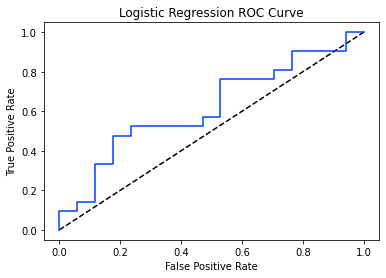

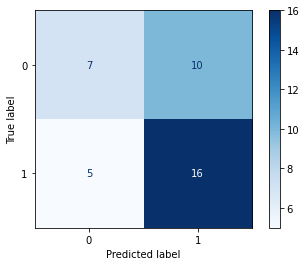

It takes 0.128 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighbors on the testing set is: 0.500
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        17
           1       0.54      0.67      0.60        21

    accuracy                           0.50        38
   macro avg       0.48      0.48      0.47        38
weighted avg       0.48      0.50      0.48        38



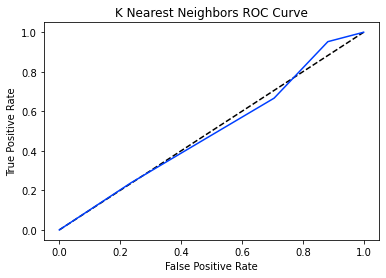

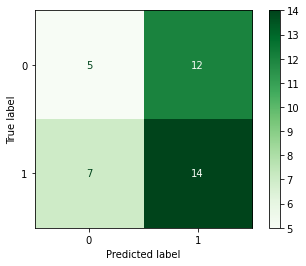

It takes 18.949 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.474
              precision    recall  f1-score   support

           0       0.40      0.35      0.38        17
           1       0.52      0.57      0.55        21

    accuracy                           0.47        38
   macro avg       0.46      0.46      0.46        38
weighted avg       0.47      0.47      0.47        38



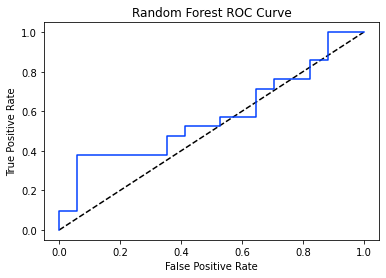

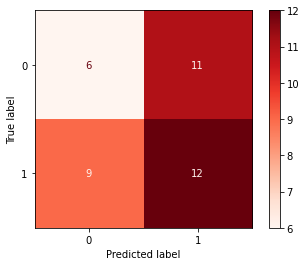

It takes 8.852 seconds for AdaBoost fitting
Accuracy with AdaBoost on the testing set is: 0.526
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        17
           1       0.55      0.76      0.64        21

    accuracy                           0.53        38
   macro avg       0.50      0.50      0.47        38
weighted avg       0.50      0.53      0.49        38



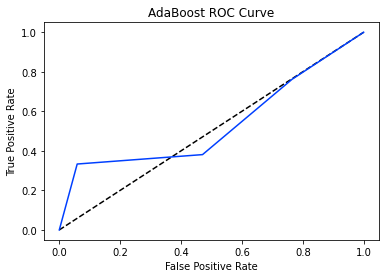

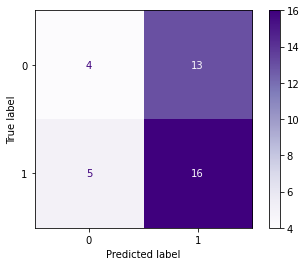

It takes 2.003 seconds for XGBoost fitting
Accuracy with XGBoost on the testing set is: 0.474
              precision    recall  f1-score   support

           0       0.43      0.59      0.50        17
           1       0.53      0.38      0.44        21

    accuracy                           0.47        38
   macro avg       0.48      0.48      0.47        38
weighted avg       0.49      0.47      0.47        38



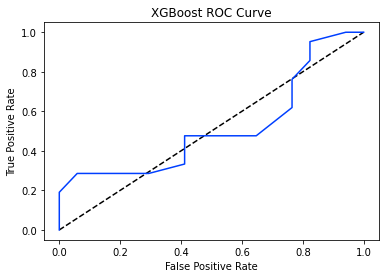

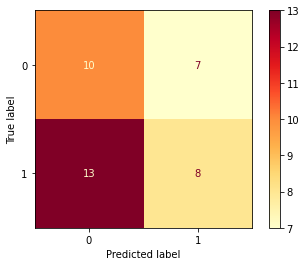

In [53]:
pipeline = Pipeline(steps=[('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

plot_confusion_matrix(lr_cv, X_test, y_test, cmap = 'Blues', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('classifier', classifier_knn)])

knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)

plot_confusion_matrix(knn_cv, X_test, y_test, cmap = 'Greens', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('classifier', classifier_rf)])

rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

plot_confusion_matrix(rf_cv, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('classifier', classifier_ada)])

ada_cv = train_and_score_model('AdaBoost', pipeline, param_grid_ada)

plot_confusion_matrix(ada_cv, X_test, y_test, cmap = 'Purples', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('classifier', classifier_xgb)])
xgb_cv = train_and_score_model('XGBoost', pipeline, param_grid_xgb)

plot_confusion_matrix(xgb_cv, X_test, y_test, cmap = 'YlOrRd', values_format = '')
plt.grid(False)
plt.show()

Well this is not good.  Random Forest actually performed worse after hyperparameter tuning.  It looks like Logistic Regression performed the best but let's take a look at another run with Random Forest and determine what features were most important to the model. We will take the best parameters and change the seed for a different trial while we bump down the test size.  Maybe the model does not have enough observations to learn from.

In [54]:
rf_cv.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__max_features': 2,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 7,
 'classifier__n_estimators': 287}

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1111, stratify=y)

In [64]:
rf_classifier = RandomForestClassifier(random_state=1111, criterion='gini', max_depth=10, 
                                       max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=287)

It takes 0.312 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.538
ROC AUC score is: 0.598
              precision    recall  f1-score   support

           0       0.50      0.25      0.33        12
           1       0.55      0.79      0.65        14

    accuracy                           0.54        26
   macro avg       0.53      0.52      0.49        26
weighted avg       0.53      0.54      0.50        26



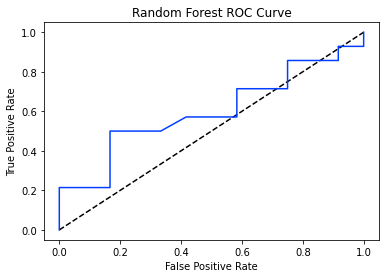

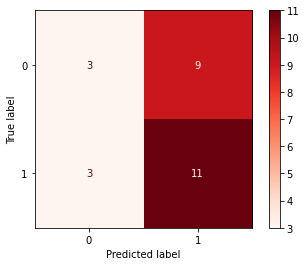

In [65]:
t0 = time.time()
rf_classifier.fit(X_train, y_train)
ttt = time.time() - t0
print("It takes %.3f seconds for %s fitting" % (ttt, 'Random Forest'))

y_pred = rf_classifier.predict(X_test)

print("Accuracy with " + 'Random Forest' + " on the testing set is: %.3f" % rf_classifier.score(X_test, y_test))
    
y_pred_prob = rf_classifier.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Random Forest')
plt.show()

plot_confusion_matrix(rf_classifier, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

Well, we got better accuracy but we are nowhere close to a model that can be used in production.  Let's see what features are driving this model.

In [66]:
def plot_feature_importance(importance, names, model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance to Model')
  plt.ylabel('Features')

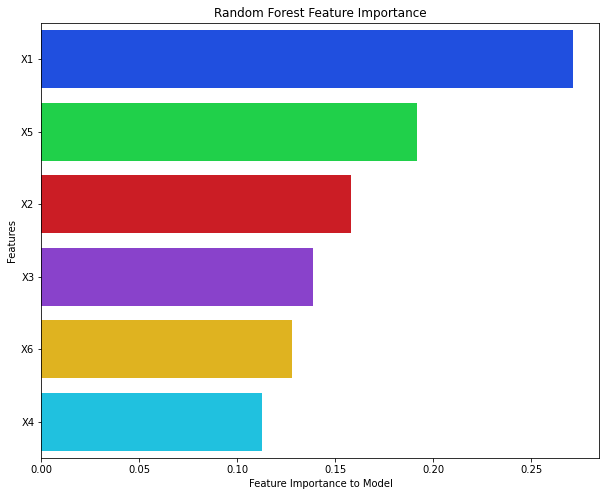

In [67]:
plot_feature_importance(rf_classifier.feature_importances_, X_train.columns,'Random Forest')

It looks like feature X1 is the most important.  Let's take out features X4 and X6 to see if that improves the model.

In [68]:
new_features = ['X1', 'X2', 'X3', 'X5']
X = df[new_features]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2222, stratify=y)

It takes 0.453 seconds for Logistic Regression fitting
Accuracy with Logistic Regression on the testing set is: 0.692
              precision    recall  f1-score   support

           0       0.83      0.42      0.56        12
           1       0.65      0.93      0.76        14

    accuracy                           0.69        26
   macro avg       0.74      0.67      0.66        26
weighted avg       0.73      0.69      0.67        26



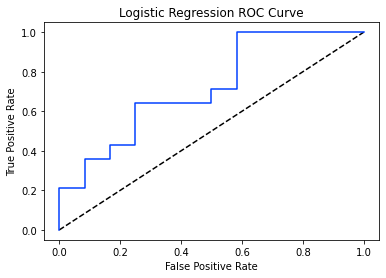

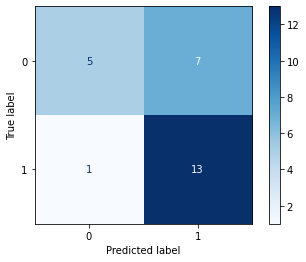

It takes 0.167 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighbors on the testing set is: 0.538
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.57      0.57      0.57        14

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26



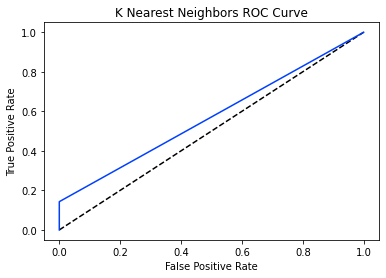

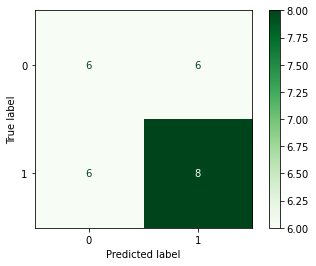

It takes 14.176 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.731
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.73      0.79      0.76        14

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



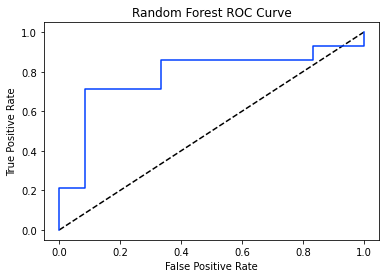

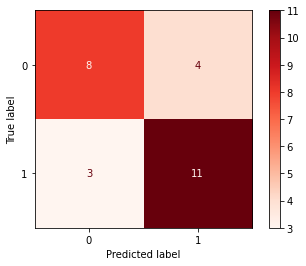

It takes 12.517 seconds for AdaBoost fitting
Accuracy with AdaBoost on the testing set is: 0.654
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.67      0.71      0.69        14

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26



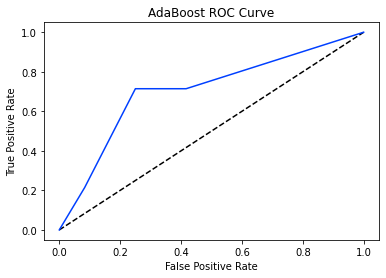

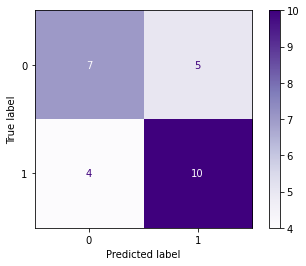

It takes 1.369 seconds for XGBoost fitting
Accuracy with XGBoost on the testing set is: 0.654
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.65      0.79      0.71        14

    accuracy                           0.65        26
   macro avg       0.66      0.64      0.64        26
weighted avg       0.66      0.65      0.65        26



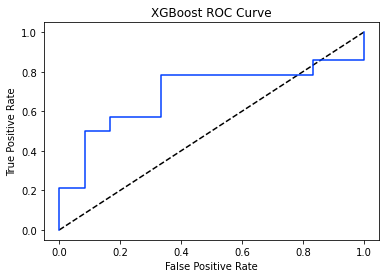

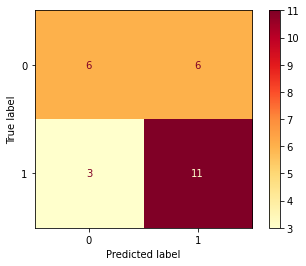

In [77]:
pipeline = Pipeline(steps=[('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

plot_confusion_matrix(lr_cv, X_test, y_test, cmap = 'Blues', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('classifier', classifier_knn)])

knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)

plot_confusion_matrix(knn_cv, X_test, y_test, cmap = 'Greens', values_format = '')
plt.grid(False)
plt.show()
    
pipeline = Pipeline(steps=[('classifier', classifier_rf)])

rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

plot_confusion_matrix(rf_cv, X_test, y_test, cmap = 'Reds', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('classifier', classifier_ada)])

ada_cv = train_and_score_model('AdaBoost', pipeline, param_grid_ada)

plot_confusion_matrix(ada_cv, X_test, y_test, cmap = 'Purples', values_format = '')
plt.grid(False)
plt.show()

pipeline = Pipeline(steps=[('classifier', classifier_xgb)])
xgb_cv = train_and_score_model('XGBoost', pipeline, param_grid_xgb)

plot_confusion_matrix(xgb_cv, X_test, y_test, cmap = 'YlOrRd', values_format = '')
plt.grid(False)
plt.show()

In [78]:
rf_cv.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 4,
 'classifier__max_features': 4,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 401}

In [79]:
from pandas.plotting import table
o.astype(float).round(3)
model_metrics = o.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
model_metrics

,Logistic Regression,K Nearest Neighbors,Random Forest,AdaBoost,XGBoost
accuracy,69.2,53.8,73.1,65.4,65.4
precision,65.0,57.1,73.3,66.7,64.7
recall,92.9,57.1,78.6,71.4,78.6
AUC,72.0,57.1,78.0,70.5,69.0


## **Conclusion**

The graph above depicts the performance of the machine learning models used.  Random Forest delivered an accuracy of 73.1% while Logistic Regression performed just under 70% after removing features X4 and X6.  This means that asking customers if they paid a good price for the order and the app makes ordering easier may not be leading to insight as to whether customers are happy with ACME.  While this is a good start and it seems that gathering information for ACME is difficult, four features is not a large number and more observations could lead to even greater insight with the ability to use XGBoost to predict happiness of customers.  Also, a Light Gradient Boosting Machine may perform better than the bagging tendencies of Random Forest despite the algorithm out-performing AdaBoost. Eliminating one of the features between X5 and X6 was also a wise choice as they were positively correlated with X1 and this behavior has a tendency to provide inflated results. Feature X1 is the most important feature for the Random Forest model meaning that prompt delivery of orders to customers is paramount.   